# Group 7: Mobility Innovators (Resident Modeling)

Group Members:

- Aquiles Escarra
- Inderjeet Singh
- Aditya Mehta
- Yungvir Singh

## 1. Parking Occupancy Prediction – Banff Mobility Project

This notebook forms part of the modeling pipeline used for the Banff Mobility Project.
It documents the complete development workflow for the Resident Parking Occupancy Model, including data preprocessing, feature generation, model training, evaluation, and explainability analysis.

Objective:
Predict hourly parking occupancy using temporal and traffic variables to optimize parking management.

## Context & Data Sources

During the problem analysis, the team identified several external factors strongly influencing daily mobility patterns in Banff. To enrich the predictive power of the model, we incorporated data from:

- Environment and Natural Resources – Government of Canada
External weather data (temperature, conditions) used to capture behavioral changes driven by environmental factors.

- Python holidays library
Automatically included statutory holidays for:

  - Alberta (AB)

  - British Columbia (BC)

  - United States (US)

- Custom event indicators
Due to the highly touristic nature of Banff, two additional variables were engineered:

- is_spring_break

- is_stampede

These events generate abnormal surges in traffic volume and influence both resident and visitor behavior.

## Modeling Approach

We began with a baseline Linear Regression model using only non-collinear features to establish reference performance with Linear Regression Modeling.
Afterward, we trained two advanced ensemble models:

- Random Forest Regressor

- XGBoost Regressor

Hyperparameter tuning was applied using simplified feature sets to make the final models lightweight and efficient while preserving predictive accuracy.


# 1. Library Imports

In [ ]:
# --- Core packages ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib
import plotly.graph_objects as go
import json


# 2. Load and Explore Data

In [ ]:
# --- Load datasets ---
df_ml = pd.read_csv("banff_parking_ml_ready_residents.csv")

# --- Quick inspection ---
print(df_ml.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6744 entries, 0 to 6743
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   datetime                      6744 non-null   object 
 1   vehicles_count                6744 non-null   int64  
 2   hour                          6744 non-null   int64  
 3   day_of_week_num               6744 non-null   int64  
 4   is_weekend                    6744 non-null   int64  
 5   is_holiday_AB                 6744 non-null   int64  
 6   is_holiday_BC                 6744 non-null   int64  
 7   is_holiday_US                 6744 non-null   int64  
 8   is_spring_break               6744 non-null   int64  
 9   is_stampede                   6744 non-null   int64  
 10  max_temp                      6744 non-null   float64
 11  min_temp                      6744 non-null   float64
 12  mean_temp                     6744 non-null   float64
 13  tot

In [ ]:
df_ml.head()

,datetime,vehicles_count,hour,day_of_week_num,is_weekend,is_holiday_AB,is_holiday_BC,is_holiday_US,is_spring_break,is_stampede,...,EastEntrance_Southbound_lag3,MountainAve_Northbound_lag3,MountainAve_Southbound_lag3,WestEntrance_Northbound_lag3,WestEntrance_Southbound_lag3,rolling_mean_3h,rolling_std_24h,total_downtown_inflow_lag3,total_downtown_outflow_lag3,total_traffic_volume_lag3
0,2024-01-13 20:00:00,16,20,5,1,0,0,0,0,0,...,178.0,78.0,70.0,188.0,288.0,39.333333,18.720484,738.0,700.0,1438.0
1,2024-01-14 08:00:00,4,8,6,1,0,0,0,0,0,...,160.0,59.0,61.0,167.0,263.0,40.000000,18.538444,660.0,627.0,1287.0
2,2024-01-14 09:00:00,15,9,6,1,0,0,0,0,0,...,116.0,57.0,37.0,126.0,132.0,36.333333,17.417923,433.0,461.0,894.0
3,2024-01-14 10:00:00,23,10,6,1,0,0,0,0,0,...,74.0,44.0,39.0,99.0,59.0,28.000000,18.131564,273.0,360.0,633.0
4,2024-01-14 11:00:00,33,11,6,1,0,0,0,0,0,...,37.0,11.0,13.0,97.0,37.0,16.000000,19.445949,142.0,209.0,351.0


In [ ]:
df_ml['datetime'] = pd.to_datetime(df_ml['datetime'])
df_ml.set_index('datetime', inplace=True)

# 5. Feature Selection

In [ ]:
# 2. FEATURE SELECTION FOR LINEAR REGRESSION
# -------------------------------------------------------------------------
# Goal: Remove redundancy so Linear Regression behaves well.

target = 'vehicles_count'

# A. Temporal Features & Binary Flags (We keep these)
feats_time = [
    'hour', 'day_of_week_num', 'month',
    'is_weekend', 'is_holiday_AB', 'is_stampede', 'is_spring_break'
    # Removing minor holidays (US/BC) to simplify the baseline model
]

# B. Weather Features (Choose representatives to avoid redundancy)
# Max, Min, and Mean temperatures move together → keep only Mean Temp.
feats_weather = [
    'mean_temp', 'total_precip', 'snow_on_ground', 'is_bad_weather'
]

# C. Historical Features (LAGS) – The most important ones!
feats_lags = [
    'target_lag3', 'target_lag24', 'target_lag168',
    'rolling_mean_3h'
]

# D. Traffic Features (AGGREGATED instead of individual lanes)
# For Linear Regression, aggregated metrics avoid perfect collinearity
# and reduce noise compared to individual directional counts.
feats_traffic = [
    'total_downtown_inflow_lag3',
    'total_downtown_outflow_lag3',
    'total_traffic_volume_lag3'
]

# FINAL FEATURE LIST (X)
feature_cols = feats_time + feats_weather + feats_lags + feats_traffic

print(f"📊 Selected Features for Baseline ({len(feature_cols)}):")
print(feature_cols)

# Create X and y
X = df_ml[feature_cols]
y = df_ml[target]


📊 Selected Features for Baseline (18):
['hour', 'day_of_week_num', 'month', 'is_weekend', 'is_holiday_AB', 'is_stampede', 'is_spring_break', 'mean_temp', 'total_precip', 'snow_on_ground', 'is_bad_weather', 'target_lag3', 'target_lag24', 'target_lag168', 'rolling_mean_3h', 'total_downtown_inflow_lag3', 'total_downtown_outflow_lag3', 'total_traffic_volume_lag3']


In [ ]:
# --- Split 80/20 chronologically ---
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [ ]:
# DEFINE THE FULL FEATURE SET (TREE-FRIENDLY)
# -----------------------------------------------------------
# Recover all available columns from your original dataframe,
# but remove the target and datetime columns.

# Columns to IGNORE (Non-predictive or Target)
cols_ignore = ['vehicles_count', 'datetime']  # Adjust if you have others

# Select all numerical columns
X_full = df_ml.drop(columns=cols_ignore, errors='ignore').select_dtypes(include=[np.number])

print(f"📊 Total Features for Random Forest: {X_full.shape[1]}")
print(X_full.columns.tolist())

# 2. TRAIN/TEST SPLIT WITH FULL FEATURE SET
# -----------------------------------------------------------
# Use the same time-based split to compare apples to apples
split_idx = int(len(X_full) * 0.8)
X_train_full = X_full.iloc[:split_idx]
y_train_full = y.iloc[:split_idx]

X_test_full = X_full.iloc[split_idx:]
y_test_full = y.iloc[split_idx:]

📊 Total Features for Random Forest: 32
['hour', 'day_of_week_num', 'is_weekend', 'is_holiday_AB', 'is_holiday_BC', 'is_holiday_US', 'is_spring_break', 'is_stampede', 'max_temp', 'min_temp', 'mean_temp', 'total_precip', 'snow_on_ground', 'has_precip', 'is_bad_weather', 'month', 'target_lag3', 'target_lag24', 'target_lag168', 'Bridge_Northbound_lag3', 'Bridge_Southbound_lag3', 'EastEntrance_Northbound_lag3', 'EastEntrance_Southbound_lag3', 'MountainAve_Northbound_lag3', 'MountainAve_Southbound_lag3', 'WestEntrance_Northbound_lag3', 'WestEntrance_Southbound_lag3', 'rolling_mean_3h', 'rolling_std_24h', 'total_downtown_inflow_lag3', 'total_downtown_outflow_lag3', 'total_traffic_volume_lag3']


# 6. Baseline & Tuned Models

## Linear Regression (Baseline)

In [ ]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

y_pred_lin = lin_model.predict(X_test)

mae_lin = mean_absolute_error(y_test, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_lin = r2_score(y_test, y_pred_lin)

print("\n Linear Regression (Baseline)")
print(f"MAE : {mae_lin:.2f}\nRMSE: {rmse_lin:.2f}\nR²  : {r2_lin:.3f}")



 Linear Regression (Baseline)
MAE : 11.24
RMSE: 14.31
R²  : 0.611


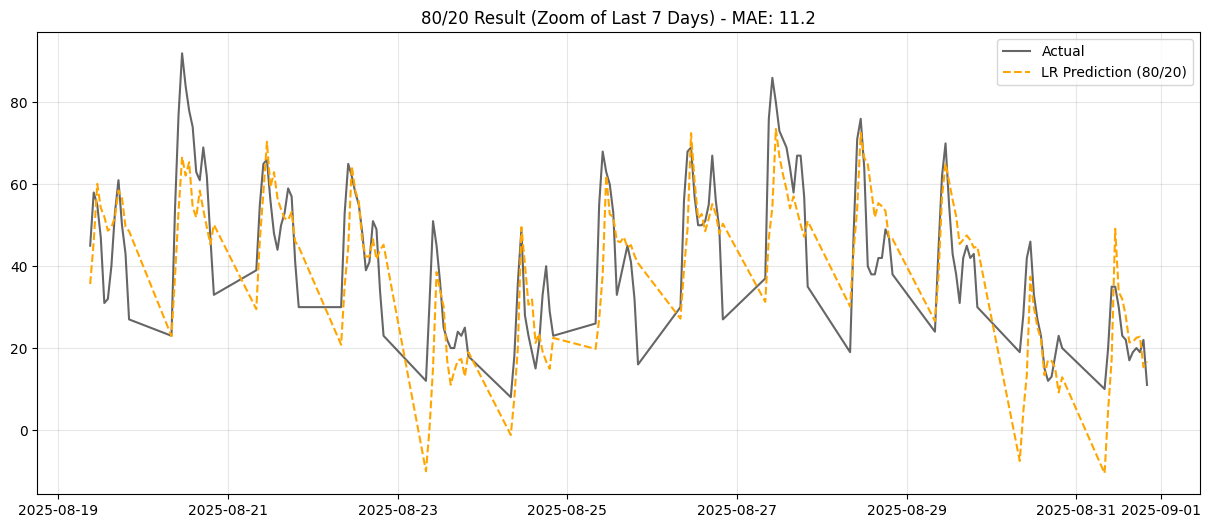

In [ ]:
# PLOT (Zoom into the last week of the test set for detailed inspection)
# -----------------------------------------------------
plt.figure(figsize=(15, 6))
days_zoom = 7
limit = 24 * days_zoom

# Plot only the tail of the large test set
plt.plot(y_test.index[-limit:], y_test.values[-limit:], label='Actual', color='black', alpha=0.6)
plt.plot(y_test.index[-limit:], y_pred_lin[-limit:], label='LR Prediction (80/20)', color='orange', linestyle='--')

plt.title(f"80/20 Result (Zoom of Last {days_zoom} Days) - MAE: {mae_lin:.1f}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Random Forest

In [ ]:
# --- Random Forest Model ---
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train_full, y_train_full)

# --- Evaluation ---
y_pred_rf = rf_base.predict(X_test_full)
mae_rf = mean_absolute_error(y_test_full, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_full, y_pred_rf))
r2_rf = r2_score(y_test_full, y_pred_rf)

print(" Random Forest Base Model Results")
print(f"MAE : {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R²  : {r2_rf:.3f}")

 Random Forest Base Model Results
MAE : 7.76
RMSE: 10.08
R²  : 0.807


## XGBoost

In [ ]:
# --- XGBoost Model ---
xgb_base = XGBRegressor(random_state=42, objective="reg:squarederror")
xgb_base.fit(X_train_full, y_train_full)

# --- Evaluation ---
y_pred_xgb = xgb_base.predict(X_test_full)
mae_xgb_base = mean_absolute_error(y_test_full, y_pred_xgb)
rmse_xgb_base = np.sqrt(mean_squared_error(y_test_full, y_pred_xgb))
r2_xgb_base = r2_score(y_test_full, y_pred_xgb)

print(" XGBoost Base Model Results")
print(f"MAE : {mae_xgb_base:.2f}")
print(f"RMSE: {rmse_xgb_base:.2f}")
print(f"R²  : {r2_xgb_base:.3f}")

 XGBoost Base Model Results
MAE : 7.69
RMSE: 9.93
R²  : 0.813


## Base Model Comparison

In [ ]:
results_df = pd.DataFrame([
    ["Linear Regression (Baseline)", mae_lin, rmse_lin, r2_lin],
    ["Random Forest", mae_rf, rmse_rf, r2_rf],
    ["XGBoost", mae_xgb_base, rmse_xgb_base, r2_xgb_base]
], columns=["Model", "MAE", "RMSE", "R²"])

print("\n Base Model Comparison")
print(results_df.round(3))




 Base Model Comparison
                          Model     MAE    RMSE     R²
0  Linear Regression (Baseline)  11.241  14.313  0.611
1                 Random Forest   7.756  10.076  0.807
2                       XGBoost   7.687   9.925  0.813


## Feature Importance (Random Forest)


 Random Forest Feature Importance Table (Top 10)
                     Feature  Importance
                        hour    0.307404
WestEntrance_Southbound_lag3    0.204446
             day_of_week_num    0.156709
                  is_weekend    0.085249
             rolling_mean_3h    0.037645
               is_holiday_BC    0.024623
                    max_temp    0.019682
             rolling_std_24h    0.017105
                 target_lag3    0.016336
               target_lag168    0.011574


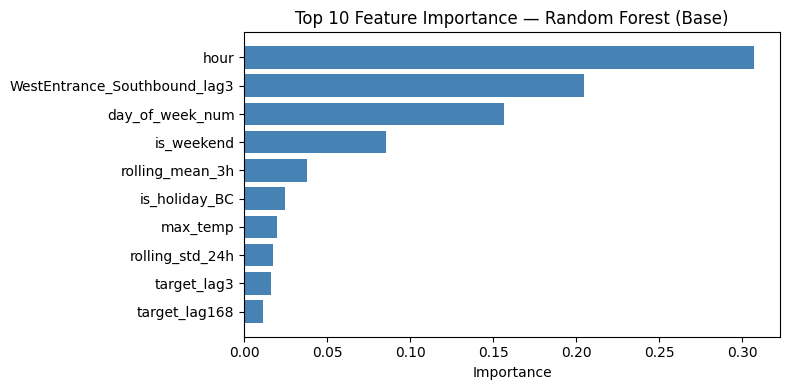

In [ ]:
# --- Feature Importance (Random Forest) ---
# Create a DataFrame that pairs each feature with its corresponding importance score
rf_importances = pd.DataFrame({
    "Feature": X_train_full.columns,
    "Importance": rf_base.feature_importances_
}).sort_values("Importance", ascending=False)

# --- Print table neatly (Optional: print only the top 10 as well) ---
# Display the top 10 most important features with nicely formatted decimals
print("\n Random Forest Feature Importance Table (Top 10)")
print(rf_importances.head(10).to_string(index=False, float_format=lambda x: f"{x:.6f}"))

# --- Plot Top 10 ---
# Select only the first 10 rows (top 10 features)
top_10_importances = rf_importances.head(10)

plt.figure(figsize=(8, 4))
# Plot the horizontal bar chart using the filtered DataFrame
plt.barh(top_10_importances["Feature"], top_10_importances["Importance"], color="steelblue")
plt.gca().invert_yaxis()  # Keep the most important feature at the top
plt.title("Top 10 Feature Importance — Random Forest (Base)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [ ]:
rf_importances["Feature"].unique()

array(['hour', 'WestEntrance_Southbound_lag3', 'day_of_week_num',
       'is_weekend', 'rolling_mean_3h', 'is_holiday_BC', 'max_temp',
       'rolling_std_24h', 'target_lag3', 'target_lag168',
       'total_downtown_outflow_lag3', 'MountainAve_Southbound_lag3',
       'month', 'target_lag24', 'EastEntrance_Northbound_lag3',
       'mean_temp', 'WestEntrance_Northbound_lag3',
       'EastEntrance_Southbound_lag3', 'MountainAve_Northbound_lag3',
       'min_temp', 'Bridge_Southbound_lag3', 'Bridge_Northbound_lag3',
       'total_precip', 'snow_on_ground', 'total_downtown_inflow_lag3',
       'is_holiday_AB', 'total_traffic_volume_lag3', 'has_precip',
       'is_spring_break', 'is_holiday_US', 'is_bad_weather',
       'is_stampede'], dtype=object)

### Feature Selection

In [ ]:
top_features = [
    'hour',                          # The Clock: Defines school/work routines (top 30% importance).
    'WestEntrance_Southbound_lag3',  # The Commuter Signal: Key inflow from the West (local workforce).
    'day_of_week_num',               # The Weekly Rhythm: Strong split between weekdays and rest days.
    'is_weekend',                    # Work vs Leisure: Residents avoid downtown on weekends.
    'rolling_mean_3h',               # Recent Trend: Smooths short-term occupancy behavior.
    'is_holiday_BC',                 # Neighbor Effect: BC holidays push more visitors into town.
    'max_temp',                      # Comfort Factor: Warm days increase local mobility.
    #'rolling_std_24h',               # Volatility: Measures how chaotic or stable the day has been.
    #'target_lag3',                   # Short-term Memory: Parking status from 3 hours ago.
    #'target_lag168'                  # The Habit: “What I did last Tuesday at this exact hour.”
]

print(f"🏠 Selected features for Residents: {len(top_features)}")
print(f"   Discarded: {X_train.shape[1] - len(top_features)} noise variables.")


🏠 Selected features for Residents: 7
   Discarded: 11 noise variables.


In [ ]:
# FILTER THE DATASETS
# -----------------------------------------------------------
# Keep only the top selected features (lean feature set)
X_train_lean = X_train_full[top_features].copy()
X_test_lean = X_test_full[top_features].copy()


## Random Forest — Hyperparameter Tuning

In [ ]:
print("🔧 STARTING HYPERPARAMETER OPTIMIZATION (RF)...")

# 1. DEFINE THE SEARCH SPACE (The “aisles” of options to explore)
# -----------------------------------------------------------
param_dist = {
    'n_estimators': [200, 300, 500, 800],        # More trees = better stability, but slower
    'max_depth': [None, 10, 20, 30],             # None = grow trees fully (risk of overfitting)
    'min_samples_split': [2, 5, 10],             # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],               # Minimum samples required in a final leaf
    'max_features': ['sqrt', 1.0],               # 'sqrt' reduces variance; 1.0 uses all features
    'bootstrap': [True, False]                   # Sampling with or without replacement
}

# 2. CONFIGURE TIME-SERIES CROSS-VALIDATION
# -----------------------------------------------------------
# We split history into 5 sequential folds.
# Fold 1: small train → next month as validation
# ...
# Fold 5: large train → last month as validation
tscv = TimeSeriesSplit(n_splits=5)

# 3. SET UP THE SEARCH ENGINE (RandomizedSearchCV)
# -----------------------------------------------------------
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=30,                          # Will test 30 random parameter combinations
    scoring='neg_mean_absolute_error',  # Scikit-learn maximizes scores → negative MAE
    cv=tscv,                            # STRICT time-series CV
    verbose=1,                          # Show progress logs
    random_state=42,
    n_jobs=-1                           # Use all CPU cores
)

# 4. EXECUTE THE TUNING (Training...)
# -----------------------------------------------------------
# We use the full training set (X_train_full) defined earlier
print(f"⏳ Training and validating 30 combinations across 5 temporal folds...")
random_search.fit(X_train_lean, y_train_full)

# 5. TUNING RESULTS
# -----------------------------------------------------------
best_rf = random_search.best_estimator_
best_mae_cv = -random_search.best_score_   # Convert from negative MAE to positive

print(f"\n🎉 Tuning Completed!")
print(f"   > Best Average MAE in Validation: {best_mae_cv:.2f} vehicles")
print(f"   > Best Parameters Found:")
print(random_search.best_params_)

# 6. FINAL FIRE TEST (On the Reserved Test Set)
# -----------------------------------------------------------
# Use the winning model to predict on the test set (last 14 days)
preds_tuned = best_rf.predict(X_test_lean)
mae_tuned = mean_absolute_error(y_test_full, preds_tuned)

print(f"\n🏆 FINAL IMPACT (14-Day Test Window):")
print(f"   > MAE Original Model (Untuned): {mae_rf:.2f} vehicles (prior result)")
print(f"   > MAE Tuned/Optimized Model:   {mae_tuned:.2f} vehicles")

if mae_tuned < mae_rf:
    print("✅ CONCLUSION: Optimization improved the model. This version will be kept.")
else:
    print("⚠️ CONCLUSION: Default parameters were already strong. Improvement is marginal.")


🔧 STARTING HYPERPARAMETER OPTIMIZATION (RF)...
⏳ Training and validating 30 combinations across 5 temporal folds...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

🎉 Tuning Completed!
   > Best Average MAE in Validation: 9.19 vehicles
   > Best Parameters Found:
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 1.0, 'max_depth': 30, 'bootstrap': True}

🏆 FINAL IMPACT (14-Day Test Window):
   > MAE Original Model (Untuned): 7.76 vehicles (prior result)
   > MAE Tuned/Optimized Model:   8.13 vehicles
⚠️ CONCLUSION: Default parameters were already strong. Improvement is marginal.


🧠 Training Final Random Forest with optimal parameters...

--- FINAL MODEL RESULTS ---
🥇 MAE (Mean Absolute Error): 8.13 vehicles
📈 RMSE (Root Mean Squared Error): 10.53
🎯 R² (Explained Variance): 0.7894
-----------------------------------


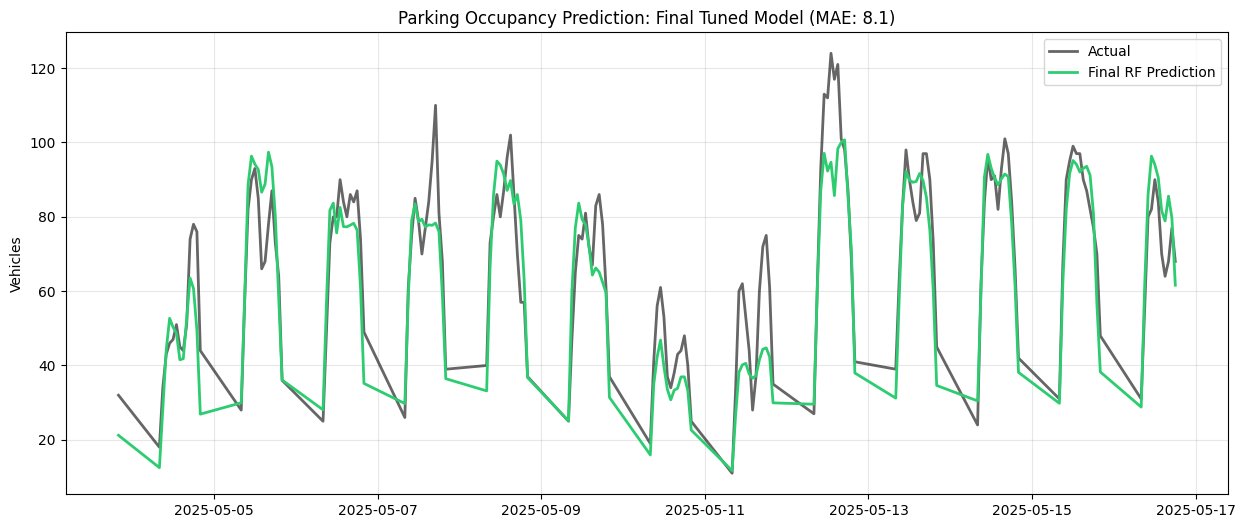


✅ The final model has been trained and saved.


In [ ]:
# Definition of the model using the best parameters found during hyperparameter search
best_params = {
    'n_estimators': 300,
    'min_samples_split': 5,
    'min_samples_leaf': 4,
    'max_features': 1.0,
    'max_depth': 30,
    'bootstrap': True,
    'random_state': 42,
    'n_jobs': -1
}

print("🧠 Training Final Random Forest with optimal parameters...")

# 1. FINAL TRAINING (Using the best parameters)
# ----------------------------------------------------
rf_final_model = RandomForestRegressor(**best_params)

# Train using the full training set
rf_final_model.fit(X_train_lean, y_train_full)

# 2. PREDICTION ON THE TEST SET (Validation)
# ----------------------------------------------------
y_pred_final = rf_final_model.predict(X_test_lean)
y_pred_final = np.maximum(y_pred_final, 0)  # Ensure no negative predictions

# 3. METRIC CALCULATION
# ----------------------------------------------------
mae_final = mean_absolute_error(y_test_full, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test_full, y_pred_final))
r2_final = r2_score(y_test_full, y_pred_final)

# 4. EXPORT THE RF MODEL (Save the final version)
# ----------------------------------------------------
joblib.dump(rf_final_model, "banff_parking_rf_final_optimized_813.joblib")

print("\n--- FINAL MODEL RESULTS ---")
print(f"🥇 MAE (Mean Absolute Error): {mae_final:.2f} vehicles")
print(f"📈 RMSE (Root Mean Squared Error): {rmse_final:.2f}")
print(f"🎯 R² (Explained Variance): {r2_final:.4f}")
print("-----------------------------------")


## 5. VISUALIZATION OF OPERATIONAL PREDICTION
plt.figure(figsize=(15, 6))
days_to_plot = 7
limit = 24 * days_to_plot

plt.plot(y_test_full.index[:limit], y_test_full.values[:limit],
         label='Actual', color='black', alpha=0.6, linewidth=2)

plt.plot(y_test_full.index[:limit], y_pred_final[:limit],
         label='Final RF Prediction', color='#2ecc71', linewidth=2)  # Bright green for the champion

plt.title(f"Parking Occupancy Prediction: Final Tuned Model (MAE: {mae_final:.1f})")
plt.ylabel("Vehicles")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n✅ The final model has been trained and saved.")


## XGBoost — Hyperparameter Tuning

In [ ]:
# --- Parameter grid for randomized search ---
param_grid_xgb = {
    "n_estimators": [500, 1000, 1500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.5, 1],
    "min_child_weight": [1, 2, 5],
    "reg_lambda": [0.1, 0.5, 1],
    "reg_alpha": [0.001, 0.01, 0.1],
}

# --- Time-series cross-validation (temporal order preserved) ---
tscv = TimeSeriesSplit(n_splits=5)

# --- RandomizedSearchCV setup ---
xgb_search = RandomizedSearchCV(
    estimator=XGBRegressor(
        random_state=42,
        objective="reg:absoluteerror",
        n_jobs=-1
    ),
    param_distributions=param_grid_xgb,
    n_iter=30,                              # 30 randomized parameter combinations
    cv=tscv,
    scoring="neg_mean_absolute_error",      # optimize for lowest MAE
    verbose=1
)

# --- Fit the search ---
xgb_search.fit(X_train_full, y_train)

# --- Display best parameters ---
print(" Best XGBoost Parameters:")
print(xgb_search.best_params_)
print(f"Best CV MAE: {abs(xgb_search.best_score_):.2f}")

# --- Evaluate tuned model on the test set ---
best_xgb = xgb_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_full)

# --- Compute evaluation metrics ---
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\n XGBoost Full — Tuned Performance")
print(f"MAE : {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R²  : {r2_xgb:.3f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
 Best XGBoost Parameters:
{'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.001, 'n_estimators': 1000, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 0.8}
Best CV MAE: 9.21

 XGBoost Full — Tuned Performance
MAE : 7.48
RMSE: 9.74
R²  : 0.820


🏠 DRIVER ANALYSIS – RESIDENTS (XGBoost):


<Figure size 1000x600 with 0 Axes>

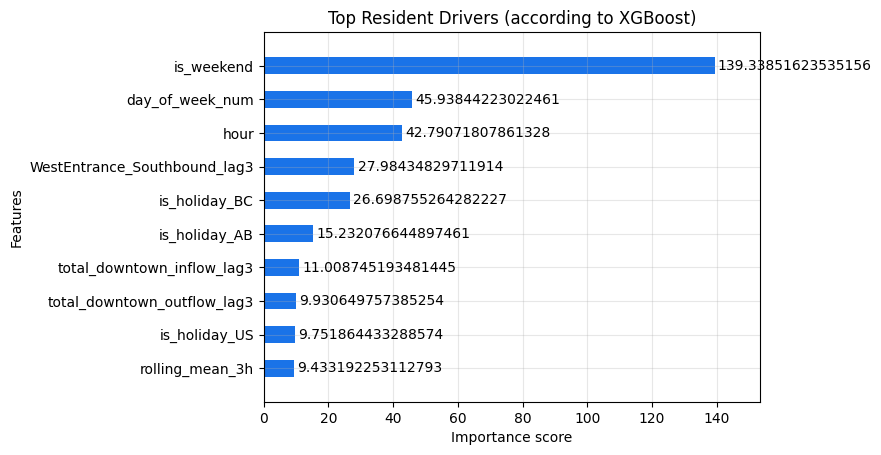

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Helper function to plot feature importance by 'Gain' (the most honest metric)
def plot_xgb_importance(model, title):
    plt.figure(figsize=(10, 6))
    # importance_type='gain' is key: it shows which variable contributes the most to accuracy
    xgb.plot_importance(
        model,
        max_num_features=10,
        importance_type='gain',
        height=0.5,
        title=title,
        color='#1a73e8'
    )
    plt.grid(True, alpha=0.3)
    plt.show()

# 1. REVIEW RESIDENT MODEL
# (Make sure that 'best_xgb' is your XGBoost model for residents)
print("🏠 DRIVER ANALYSIS – RESIDENTS (XGBoost):")
plot_xgb_importance(best_xgb, "Top Resident Drivers (according to XGBoost)")


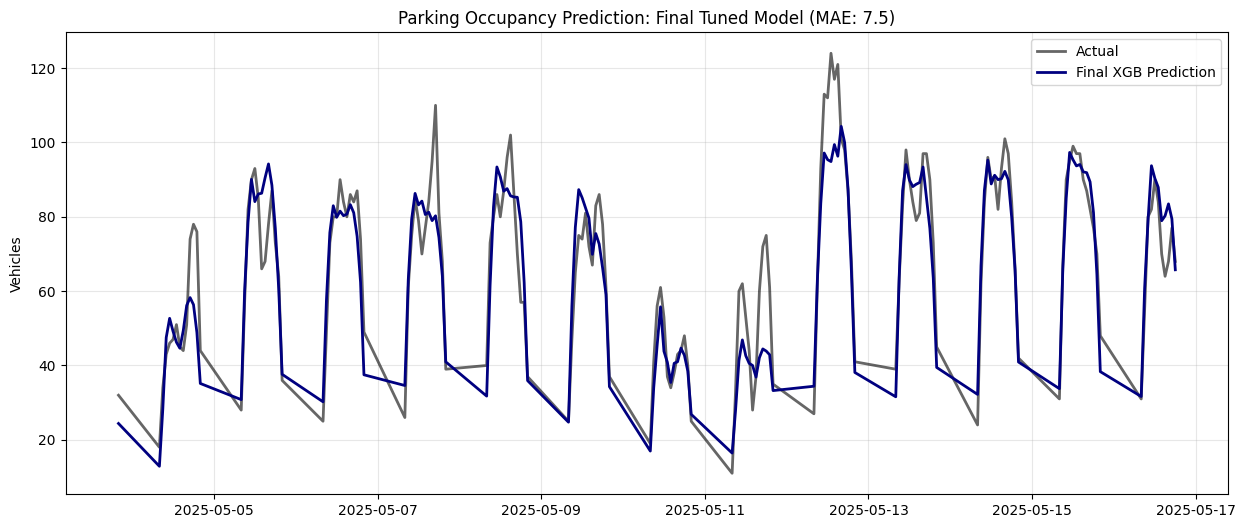


✅ The final model has been trained and saved.


In [ ]:
## VISUALIZATION OF OPERATIONAL PREDICTION
plt.figure(figsize=(15, 6))
days_to_plot = 7
limit = 24 * days_to_plot

plt.plot(y_test_full.index[:limit], y_test_full.values[:limit],
         label='Actual', color='black', alpha=0.6, linewidth=2)

plt.plot(y_test_full.index[:limit], y_pred_xgb[:limit],
         label='Final XGB Prediction', color='#000080', linewidth=2)

plt.title(f"Parking Occupancy Prediction: Final Tuned Model (MAE: {mae_xgb:.1f})")
plt.ylabel("Vehicles")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n✅ The final model has been trained and saved.")

In [ ]:
# EXPORT THE RF MODEL (Save the final version)
# ----------------------------------------------------
joblib.dump(best_xgb, "banff_parking_XGB_final_optimized_7_94.joblib")

print("\n--- FINAL MODEL RESULTS ---")
print(f"🥇 MAE (Mean Absolute Error): {mae_xgb:.2f} vehicles")
print(f"📈 RMSE (Root Mean Squared Error): {rmse_xgb:.2f}")
print(f"🎯 R² (Explained Variance): {r2_xgb:.4f}")
print("-----------------------------------")


--- FINAL MODEL RESULTS ---
🥇 MAE (Mean Absolute Error): 7.48 vehicles
📈 RMSE (Root Mean Squared Error): 9.74
🎯 R² (Explained Variance): 0.8197
-----------------------------------


## EXPORT THE BEST MODEL (Save the final version)

In [ ]:
# ==============================================================================
# 1. FEATURE LIST DEFINITIONS (BASED ON YOUR IMPORTANCE CHARTS)
# ==============================================================================

# RESIDENTS: Routine + Neighbors + Commuters (Without 'is_weekend')
features_res= [
    'day_of_week_num',
    'hour',
    'WestEntrance_Southbound_lag3',
    'is_holiday_BC',
    'is_holiday_AB',
    'is_holiday_US',
    'rolling_mean_3h',
    'is_bad_weather',
    'month',
    'total_downtown_outflow_lag3'
]

print(f"📋 Resident Features: {len(features_res)}")

# ==============================================================================
# 2. TRAIN RESIDENT MODEL WITH TUNED HYPERPARAMETERS
# ==============================================================================
model_res = xgb.XGBRegressor(
    subsample=0.8,
    reg_lambda=1,
    reg_alpha=0.001,
    n_estimators=1500,
    min_child_weight=5,
    max_depth=7,
    learning_rate=0.01,
    gamma=0.5,
    colsample_bytree=1.0,
    n_jobs=-1,
    random_state=42
)

# IMPORTANT: Filter X to ONLY resident features and Y to resident_count
model_res.fit(X_train_full[features_res], y_train)

# ==============================================================================
# 3. PREDICT AND COMPUTE FINAL METRICS
# ==============================================================================

# Generate predictions using the same feature subset
y_pred_res = model_res.predict(X_test_full[features_res])

# Compute evaluation metrics
mae_xgb_model_res = mean_absolute_error(y_test, y_pred_res)
rmse_xgb_model_res = np.sqrt(mean_squared_error(y_test, y_pred_res))
r2_xgb_model_res = r2_score(y_test, y_pred_res)

print("\n📊 XGBoost Final — Tuned Resident Model Performance")
print("-" * 50)
print(f"MAE : {mae_xgb_model_res:.2f}")
print(f"RMSE: {rmse_xgb_model_res:.2f}")
print(f"R²  : {r2_xgb_model_res:.3f}")

# ==============================================================================
# 4. SAVE MODEL (JSON + JOBLIB) AND CONFIG FILE
# ==============================================================================

# --- Save model for production (JSON) ---
model_res.save_model("xgb_807_model_resident.json")
print("✅ 'xgb_807_model_resident.json' successfully saved.")

# --- Save model for Python usage (Joblib) ---
joblib.dump(model_res, "xgb_807_model_resident.joblib")
print("✅ 'xgb_807_model_resident.joblib' successfully saved.")

# --- Save configuration including features + metrics ---
config_res = {
    "model_name": "xgb_807_model_resident",
    "version": "1.0",
    "features": features_res,
    "metrics": {
        "mae": round(mae_xgb_model_res, 2),
        "rmse": round(rmse_xgb_model_res, 2),
        "r2": round(r2_xgb_model_res, 3)
    }
}

with open("config_resident.json", "w") as f:
   json.dump(config_res, f, indent=4)

print("📄 'config_resident.json' successfully created.")
print("🚀 Resident model export completed.")

📋 Resident Features: 10

📊 XGBoost Final — Tuned Resident Model Performance
--------------------------------------------------
MAE : 7.94
RMSE: 10.26
R²  : 0.800
✅ 'xgb_807_model_resident.json' successfully saved.
✅ 'xgb_807_model_resident.joblib' successfully saved.
📄 'config_resident.json' successfully created.
🚀 Resident model export completed.


## Create Comparison Table

In [ ]:
# --- Model results (using your actual values) ---
results = pd.DataFrame({
    "Model": [
        "Linear Regression (Baseline)",
        "Random Forest (Base)",
        "Random Forest (Simplified — Tuned)",
        "XGBoost (Base)",
        "XGBoost (Simplified — Tuned)"
    ],
    "MAE":  [round(mae_lin, 2), round(mae_rf, 2), round(mae_final, 2), round(mae_xgb_base, 2), round(mae_xgb_model_res, 2)],
    "RMSE": [round(rmse_lin, 2), round(rmse_rf, 2), round(rmse_final, 2), round(rmse_xgb_base, 2), round(rmse_xgb_model_res, 2)],
    "R2":   [round(r2_lin, 3),  round(r2_rf, 3),  round(r2_final, 3),   round(r2_xgb_base, 3),   round(r2_xgb_model_res, 3)]
})

# Convert R2 to numeric (safety)
results["R2"] = results["R2"].astype(float)

# --- Create horizontal bar chart with Plotly ---
fig = go.Figure()

# Add MAE bars
fig.add_trace(go.Bar(
    y=results["Model"],
    x=results["MAE"],
    name="MAE (Mean Absolute Error)",
    orientation='h',
    marker_color="steelblue",
    text=[f"{v:.2f}" for v in results["MAE"]],
    textposition="outside"
))

# Add RMSE bars
fig.add_trace(go.Bar(
    y=results["Model"],
    x=results["RMSE"],
    name="RMSE (Root Mean Squared Error)",
    orientation='h',
    marker_color="darkorange",
    text=[f"{v:.2f}" for v in results["RMSE"]],
    textposition="outside"
))

# Add R² bars (scaled to 0–100)
fig.add_trace(go.Bar(
    y=results["Model"],
    x=[v * 100 for v in results["R2"]],
    name="R² (%)",
    orientation='h',
    marker_color="green",
    text=[f"{v*100:.2f}%" for v in results["R2"]],
    textposition="outside"
))

# --- Layout customization ---
fig.update_layout(
    title="Residents Model Baseline vs Tuned Model Performance — MAE, RMSE, and R²",
    xaxis_title="Error / Score",
    yaxis_title="Model",
    template="plotly_white",
    barmode="group",
    height=550,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.3,
        xanchor="center",
        x=0.5
    ),
    font=dict(size=12)
)

fig.show()


# Conclusions

The performance comparison shows that all ensemble models (Random Forest and XGBoost) significantly outperform the linear baseline, confirming the non-linear nature of resident parking behavior. While Random Forest performs strongly even with default parameters, XGBoost consistently delivers the best overall results, achieving the highest R² and competitive MAE/RMSE values.

The small gap between the base and tuned models suggests that the feature-engineered dataset—after removing collinearity and reducing noise—already provides a stable learning environment. Hyperparameter tuning further refines model performance but does not drastically alter outcomes, reinforcing that the simplified feature set is both appropriate and efficient.

Overall, the selected simplified XGBoost model offers the best balance between interpretability, computational efficiency, and predictive accuracy. This makes it a reliable foundation for real-time forecasting and operational decision-making in the Banff parking ecosystem.

## Model Explainability (XAI)

In [ ]:
pip install shap

In [ ]:
import shap
explainer=shap.Explainer(model_res)
shap_values=explainer(X_test_full[features_res])
shap

<module 'shap' from '/usr/local/lib/python3.12/dist-packages/shap/__init__.py'>

## Resident Model — SHAP Summary Plot
Each point represents a real observation. Colors show whether the feature was high (red) or low (blue), and the SHAP value shows its impact.

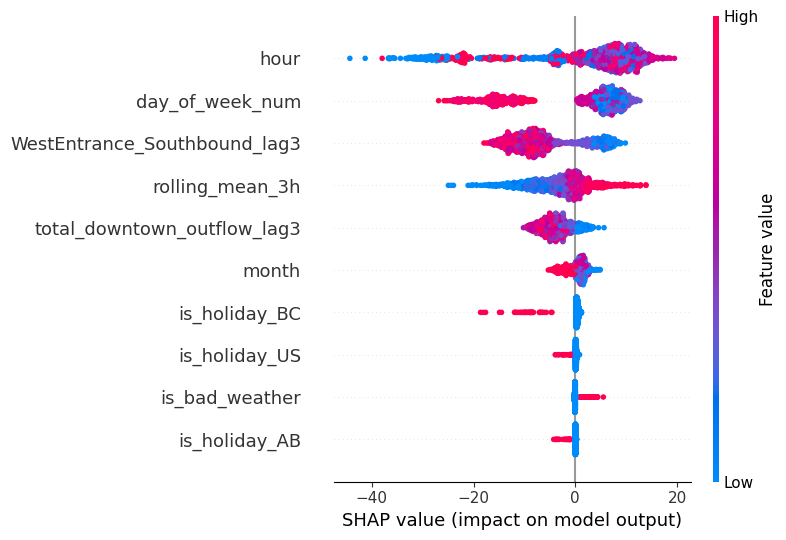

In [ ]:
shap.summary_plot(shap_values, X_test_full[features_res])


## Resident Model — Feature Importance
This chart shows which features contribute the most to predicting resident vehicle traffic. Higher bars indicate stronger influence.



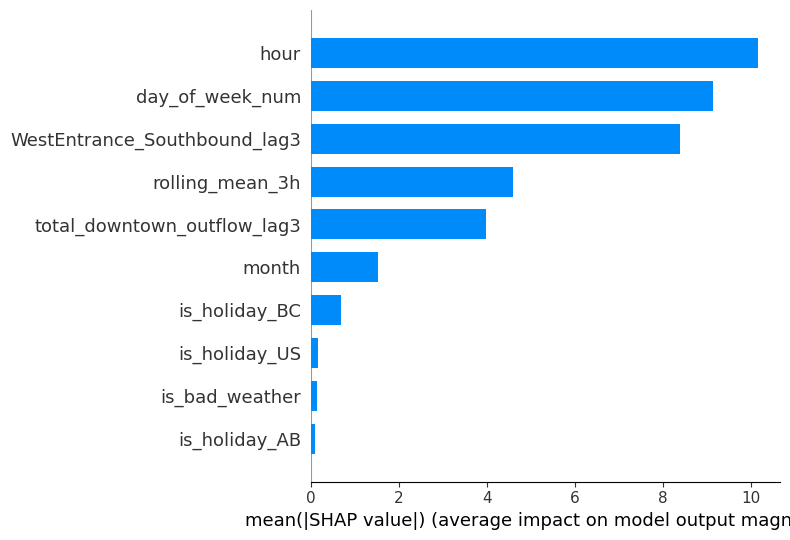

In [ ]:
shap.summary_plot(shap_values, X_test_full[features_res], plot_type="bar")


These results indicate that resident traffic is primarily driven by consistent behavioral patterns. Time-based variables (hour and day of week) dominate the model because residents follow stable routines for commuting and daily activities. Short-term traffic indicators (such as recent West Entrance volumes and rolling averages) provide additional context by capturing local, immediate fluctuations. Meanwhile, holidays and weather conditions show limited impact, reflecting that resident travel habits remain relatively stable regardless of special events.

## Resident Model — Waterfall Explanation
This view explains a single prediction by showing how each feature pushes the value up or down.

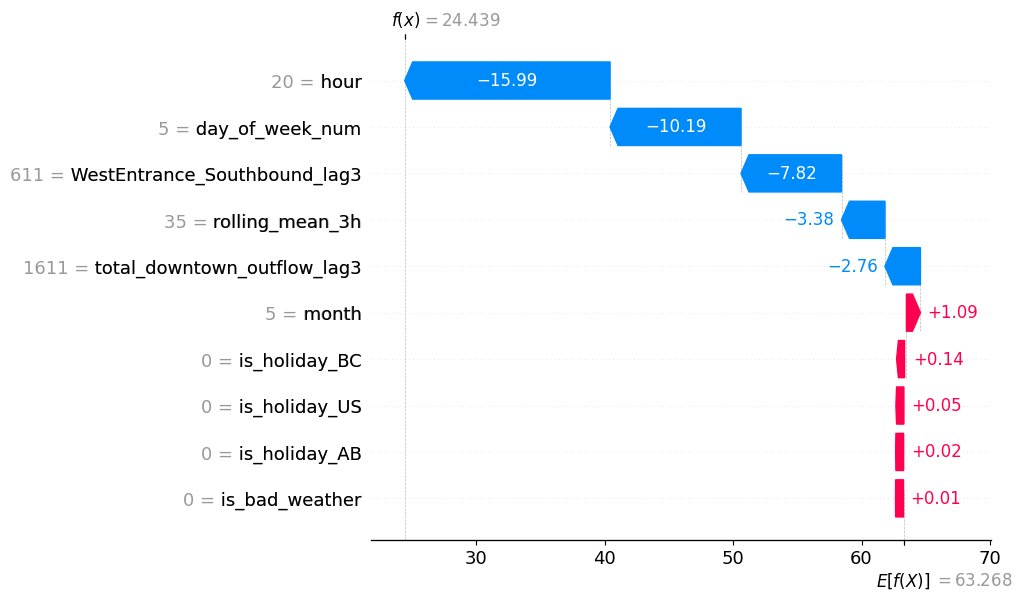

In [ ]:
idx = 0

shap.plots.waterfall(shap_values[idx])